#Ventilator

In [1]:
 from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import math

%matplotlib inline

In [3]:
path = '/content/drive/MyDrive/Ventilator_Pressure_Prediction/data/'
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
submission = pd.read_csv(path + 'sample_submission.csv')

# 간단 EDA

- id: globally-unique time step identifier across an entire file **전체 번호**
- breath_id: globally-unique time step for breaths **각 환자 번호**
- R: lung attribute indicating how restricted the airway is (in cmH2O/L/S). Physically, this is the change in pressure per change in flow (air volume per time). Intuitively, one can imagine blowing up a balloon through a straw. We can change R by changing the diameter of the straw, with higher R being harder to blow. **기도가 얼마나 막혔는지(음료를 빨대로 마실 때 빨대를 조였다 폈다하는 것과 같다) 흐름 변화당 압력 변화 ~ 높은 R일수록 불기 어렵다**
- C: lung attribute indicating how compliant the lung is (in mL/cmH2O). Physically, this is the change in volume per change in pressure. Intuitively, one can imagine the same balloon example. We can change C by changing the thickness of the balloon’s latex, with higher C having thinner latex and easier to blow. **폐의 순응력(같은 부피라도 풍선에 재질에 따라 쉽게 불러지는 것이 있고 어려운 것이 있다) 압력 변화당 부피 변화 ~ 높은 C 일수록 쉽게 불러진다**
- time_step: the actual time stamp. **각 환자의 타임스텝**
- u_in: the control input for the inspiratory solenoid valve. Ranges from 0 to 100. **inspiratory solenoid valve 흡기 벨브(?) [0.100]**
- u_out: the control input for the exploratory solenoid valve. Either 0 or 1. **exploratory solenoid valve 예비 벨브(?) 0 or 1**
- pressure: the airway pressure measured in the respiratory circuit, measured in cmH2O. **공기압(Target)**

In [ ]:
print(train.shape)
train.tail()

(6036000, 8)


,id,breath_id,R,C,time_step,u_in,u_out,pressure
6035995,6035996,125749,50,10,2.504603,1.489714,1,3.869032
6035996,6035997,125749,50,10,2.537961,1.488497,1,3.869032
6035997,6035998,125749,50,10,2.571408,1.558978,1,3.798729
6035998,6035999,125749,50,10,2.604744,1.272663,1,4.079938
6035999,6036000,125749,50,10,2.638017,1.482739,1,3.869032


In [ ]:
print(test.shape)
test.head()

(4024000, 7)


,id,breath_id,R,C,time_step,u_in,u_out
0,1,0,5,20,0.000000,0.000000,0
1,2,0,5,20,0.031904,7.515046,0
2,3,0,5,20,0.063827,14.651675,0
3,4,0,5,20,0.095751,21.230610,0
4,5,0,5,20,0.127644,26.320956,0


In [ ]:
train.describe()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
count,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06
mean,3.018000e+06,6.283886e+04,2.703618e+01,2.608072e+01,1.307225e+00,7.321615e+00,6.204493e-01,1.122041e+01
std,1.742443e+06,3.633526e+04,1.959549e+01,1.715231e+01,7.659778e-01,1.343470e+01,4.852752e-01,8.109703e+00
min,1.000000e+00,1.000000e+00,5.000000e+00,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,-1.895744e+00
25%,1.509001e+06,3.137700e+04,5.000000e+00,1.000000e+01,6.428995e-01,3.936623e-01,0.000000e+00,6.329607e+00
50%,3.018000e+06,6.276550e+04,2.000000e+01,2.000000e+01,1.308123e+00,4.386146e+00,1.000000e+00,7.032628e+00
75%,4.527000e+06,9.430100e+04,5.000000e+01,5.000000e+01,1.965502e+00,4.983895e+00,1.000000e+00,1.364103e+01
max,6.036000e+06,1.257490e+05,5.000000e+01,5.000000e+01,2.937238e+00,1.000000e+02,1.000000e+00,6.482099e+01


In [ ]:
train['R'].unique()

array([20, 50,  5])

In [ ]:
train['C'].unique()

array([50, 20, 10])

breath_id 당 개수 확인

A: 모두 80개씩

In [ ]:
print('breath_id 개수 :', len(train['breath_id'].unique()))
print('breath_id 당 개수 :', train['breath_id'].value_counts().unique())

breath_id 개수 : 75450
breath_id 당 개수 : [80]


In [ ]:
train[train['breath_id'] == 8] ## 일부는 test에 있다.

,id,breath_id,R,C,time_step,u_in,u_out,pressure


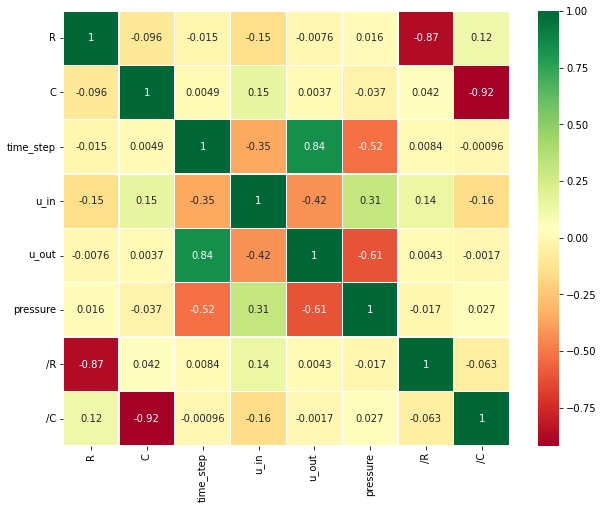

In [ ]:
sns.heatmap(train.drop(['id', 'breath_id'], axis=1).corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

# Feature Engineering

## feture engineering function

In [4]:
def engineer_features(df):
    df.loc[:, 'in0'] = (df['u_in'] == 0).astype(float)
    df.loc[:, 'in1'] = (df['u_in'] != 0).astype(float)

    df.loc[:, 'in0_out0'] = abs(df['in0'] * (df['u_out'] - 1)) * df['R'] / df['C']
    df.loc[:, 'in0_out1'] = df['in0'] * df['u_out'] * df['R'] / df['C']
    df.loc[:, 'in1_out0'] = abs(df['u_in'] * (df['u_out'] - 1)) * df['R'] / df['C']
    df.loc[:, 'in1_out1'] = df['u_in'] * df['u_out'] * df['R'] / df['C']

    df.loc[:, 'in1_out0 x time_step'] = df['in1_out0'] * df['time_step']
    df.loc[:, 'in1_out1 x time_step'] = df['in1_out1'] * df['time_step']

    df.loc[:, 'in0_out0 + time_step'] = df['in0_out0'] + df['time_step']
    df.loc[:, 'in0_out1 + time_step'] = df['in0_out1'] + df['time_step']

    df['area'] = df['time_step'] * df['u_in']
    df['area'] = df.groupby('breath_id')['area'].cumsum()
    
    df['u_in_cumsum'] = (df['u_in']).groupby(df['breath_id']).cumsum()
    
    df['u_in_lag1'] = df.groupby('breath_id')['u_in'].shift(1)
    df['u_out_lag1'] = df.groupby('breath_id')['u_out'].shift(1)
    df['u_in_lag_back1'] = df.groupby('breath_id')['u_in'].shift(-1)
    df['u_out_lag_back1'] = df.groupby('breath_id')['u_out'].shift(-1)
    df['u_in_lag2'] = df.groupby('breath_id')['u_in'].shift(2)
    df['u_out_lag2'] = df.groupby('breath_id')['u_out'].shift(2)
    df['u_in_lag_back2'] = df.groupby('breath_id')['u_in'].shift(-2)
    df['u_out_lag_back2'] = df.groupby('breath_id')['u_out'].shift(-2)
    df['u_in_lag3'] = df.groupby('breath_id')['u_in'].shift(3)
    df['u_out_lag3'] = df.groupby('breath_id')['u_out'].shift(3)
    df['u_in_lag_back3'] = df.groupby('breath_id')['u_in'].shift(-3)
    df['u_out_lag_back3'] = df.groupby('breath_id')['u_out'].shift(-3)
    df['u_in_lag4'] = df.groupby('breath_id')['u_in'].shift(4)
    df['u_out_lag4'] = df.groupby('breath_id')['u_out'].shift(4)
    df['u_in_lag_back4'] = df.groupby('breath_id')['u_in'].shift(-4)
    df['u_out_lag_back4'] = df.groupby('breath_id')['u_out'].shift(-4)
    df = df.fillna(0)
    
    df['breath_id__u_in__max'] = df.groupby(['breath_id'])['u_in'].transform('max')
    df['breath_id__u_out__max'] = df.groupby(['breath_id'])['u_out'].transform('max')
    
    df['u_in_diff1'] = df['u_in'] - df['u_in_lag1']
    df['u_out_diff1'] = df['u_out'] - df['u_out_lag1']
    df['u_in_diff2'] = df['u_in'] - df['u_in_lag2']
    df['u_out_diff2'] = df['u_out'] - df['u_out_lag2']
    
    df['breath_id__u_in__diffmax'] = df.groupby(['breath_id'])['u_in'].transform('max') - df['u_in']
    df['breath_id__u_in__diffmean'] = df.groupby(['breath_id'])['u_in'].transform('mean') - df['u_in']
    
    df['breath_id__u_in__diffmax'] = df.groupby(['breath_id'])['u_in'].transform('max') - df['u_in']
    df['breath_id__u_in__diffmean'] = df.groupby(['breath_id'])['u_in'].transform('mean') - df['u_in']
    
    df['u_in_diff3'] = df['u_in'] - df['u_in_lag3']
    df['u_out_diff3'] = df['u_out'] - df['u_out_lag3']
    df['u_in_diff4'] = df['u_in'] - df['u_in_lag4']
    df['u_out_diff4'] = df['u_out'] - df['u_out_lag4']
    df['cross']= df['u_in']*df['u_out']
    df['cross2']= df['time_step']*df['u_out']
    
    df = pd.get_dummies(df, columns=['R', 'C'], prefix=['R', 'C'], prefix_sep='')
    R_col = ['R5', 'R20', 'R50']
    C_col = ['C10', 'C20', 'C50']
    for r in R_col:
        for c in C_col:
            df.loc[:, r+c] = df[r]*df[c]

    df = df.drop(R_col+C_col, axis=1)
    df = df.drop(['u_in', 'u_out', 'in0', 'in1'], axis=1)
    df = df.drop(['id', 'breath_id'], axis=1)

    return df

## Train

In [15]:
train = engineer_features(train)
sample_size = 80
total_train_sample_num = train.shape[0] // sample_size # 75450
total_test_sample_num = test.shape[0] // sample_size # 50300

In [ ]:
print(train.shape)
train.head()

(6036000, 51)


,time_step,pressure,in0_out0,in0_out1,in1_out0,in1_out1,in1_out0 x time_step,in1_out1 x time_step,in0_out0 + time_step,in0_out1 + time_step,area,u_in_cumsum,u_in_lag1,u_out_lag1,u_in_lag_back1,u_out_lag_back1,u_in_lag2,u_out_lag2,u_in_lag_back2,u_out_lag_back2,u_in_lag3,u_out_lag3,u_in_lag_back3,u_out_lag_back3,u_in_lag4,u_out_lag4,u_in_lag_back4,u_out_lag_back4,breath_id__u_in__max,breath_id__u_out__max,u_in_diff1,u_out_diff1,u_in_diff2,u_out_diff2,breath_id__u_in__diffmax,breath_id__u_in__diffmean,u_in_diff3,u_out_diff3,u_in_diff4,u_out_diff4,cross,cross2,R5C10,R5C20,R5C50,R20C10,R20C20,R20C50,R50C10,R50C20,R50C50
0,0.000000,5.837492,0.0,0.0,0.033334,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.083334,0.000000,0.0,18.383041,0.0,0.000000,0.0,22.509278,0.0,0.000000,0.0,22.808822,0.0,0.000000,0.0,25.355850,0.0,28.313036,1,0.083334,0.0,0.083334,0.0,28.229702,10.062673,0.083334,0.0,0.083334,0.0,0.0,0.0,0,0,0,0,0,1,0,0,0
1,0.033652,5.907794,0.0,0.0,7.353217,0.0,0.247453,0.0,0.033652,0.033652,0.618632,18.466375,0.083334,0.0,22.509278,0.0,0.000000,0.0,22.808822,0.0,0.000000,0.0,25.355850,0.0,0.000000,0.0,27.259866,0.0,28.313036,1,18.299707,0.0,18.383041,0.0,9.929994,-8.237035,18.383041,0.0,18.383041,0.0,0.0,0.0,0,0,0,0,0,1,0,0,0
2,0.067514,7.876254,0.0,0.0,9.003711,0.0,0.607880,0.0,0.067514,0.067514,2.138333,40.975653,18.383041,0.0,22.808822,0.0,0.083334,0.0,25.355850,0.0,0.000000,0.0,27.259866,0.0,0.000000,0.0,27.127486,0.0,28.313036,1,4.126236,0.0,22.425944,0.0,5.803758,-12.363271,22.509278,0.0,22.509278,0.0,0.0,0.0,0,0,0,0,0,1,0,0,0
3,0.101542,11.742872,0.0,0.0,9.123529,0.0,0.926424,0.0,0.101542,0.101542,4.454391,63.784476,22.509278,0.0,25.355850,0.0,18.383041,0.0,27.259866,0.0,0.083334,0.0,27.127486,0.0,0.000000,0.0,26.807732,0.0,28.313036,1,0.299544,0.0,4.425781,0.0,5.504214,-12.662816,22.725488,0.0,22.808822,0.0,0.0,0.0,0,0,0,0,0,1,0,0,0
4,0.135756,12.234987,0.0,0.0,10.142340,0.0,1.376879,0.0,0.135756,0.135756,7.896588,89.140326,22.808822,0.0,27.259866,0.0,22.509278,0.0,27.127486,0.0,18.383041,0.0,26.807732,0.0,0.083334,0.0,27.864715,0.0,28.313036,1,2.547028,0.0,2.846573,0.0,2.957185,-15.209844,6.972809,0.0,25.272516,0.0,0.0,0.0,0,0,0,0,0,1,0,0,0


## Test

In [5]:
test = engineer_features(test)

## dataframe을 numpy로

In [6]:
target = train['pressure']

train_tmp = train.drop(['pressure'], axis=1)
feature_num = train_tmp.shape[1]

X_train = np.zeros((train_tmp.shape[0]//sample_size, sample_size, feature_num))
y_train = np.zeros((train_tmp.shape[0]//sample_size, sample_size))
for i in range(X_train.shape[0]):
    X_train[i, :, :] = train_tmp.iloc[sample_size*i : sample_size*(i+1)].to_numpy().astype(float)
    y_train[i, :] = np.array(target.iloc[sample_size*i : sample_size*(i+1)])

del train
del train_tmp

In [16]:
feature_num = test.shape[1]

X_test = np.zeros((test.shape[0]//sample_size, sample_size, feature_num))
for i in range(X_test.shape[0]):
    X_test[i, :, :] = test.iloc[sample_size*i : sample_size*(i+1)].to_numpy().astype(float)

del test

# Build Model

In [17]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import LSTM, Bidirectional, Flatten, Dense, LayerNormalization

from tensorflow.keras.regularizers import L2

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.model_selection import train_test_split, KFold

In [18]:
learning_rate_kFold = 0.0002
minibatch_size_kFold = 1024
num_epochs_kFold = 2

learning_rate_stacking = 0.0001
minibatch_size_stacking = 1024
num_epochs_stacking = 100

## K Fold

In [19]:
feature_num

50

In [20]:
class kFold_Layer(tf.keras.Model):
    def __init__(self):
        super(kFold_Layer, self).__init__()

        self.biLSTM_v1_2 = Bidirectional(LSTM(512, return_sequences=True))
        self.biLSTM_v1_3 = Bidirectional(LSTM(256, return_sequences=True))
        self.biLSTM_v1_4 = Bidirectional(LSTM(128, return_sequences=True))
        
        self.biLSTM_v2 = Bidirectional(LSTM(128, return_sequences=True))

        self.dense_v3 = Dense(256, activation='relu')

        self.layernorm = LayerNormalization(epsilon=1e-6)

        self.biLSTM2_1 = Bidirectional(LSTM(256, return_sequences=True))
        self.biLSTM2_2 = Bidirectional(LSTM(128, return_sequences=True))
        self.dense2_3 = Dense(1, activation='relu')

        self.flatten = Flatten()
    
    def call(self, X, training=True):
        # version 1
        y_v1 = self.biLSTM_v1_2(X)
        y_v1 = self.biLSTM_v1_3(y_v1)
        y_v1 = self.biLSTM_v1_4(y_v1)

        # version 2
        y_v2 = self.biLSTM_v2(X)
        
        # version 3
        y_v3 = self.dense_v3(X)

        y2 = self.layernorm(y_v1 + y_v2 + y_v3)
        y2 = self.biLSTM2_1(y2)
        y2 = self.biLSTM2_2(y2)
        y2 = self.dense2_3(y2)

        y_pred = self.flatten(y2)

        return y_pred

## OOF Stacking

In [21]:
class Stacking(tf.keras.Model):
    def __init__(self):
        super(Stacking, self).__init__()
        
        self.ffn1 = Dense(512, activation='relu')
        self.ffn2 = Dense(128, activation='relu')
        self.ffn3 = Dense(1)
        self.flatten = Flatten()
    
    def call(self, input, training=True):

        y1 = self.ffn1(input)
        y2 = self.ffn2(y1)
        y3 = self.ffn3(y2)
        y_pred = self.flatten(y3)

        return y_pred

#Training

## training functions

###K-Fold Training

In [22]:
class EarlyStpping_kFold(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
      if logs.get('mean_absolute_error') is not None and logs.get('mean_absolute_error') < 0.1:
          print("\nReached less than 0.1 MAE so cancelling training!")
          self.model.stop_training = True

In [23]:
def on_epoch_start_kFold(epoch, lr):
    if epoch <= 1:
      return learning_rate_kFold
    else:
      return lr

In [24]:
def call_kFoldModel(fold_num, learning_rate=0.001):
    tf.keras.backend.clear_session()

    Model = kFold_Layer()
    
    Model.compile(optimizer=Adam(learning_rate), loss='mean_absolute_error', metrics='mean_absolute_error')

    # weights load
    path_weights = '/content/drive/MyDrive/Ventilator_Pressure_Prediction/weights_kFold/' + fold_num + '/'

    if os.path.isdir(path_weights):
        Model.load_weights(path_weights + 'weights')
    
    return Model

In [25]:
def save_weights_kFold(Model, fold_num):
    path_weights = '/content/drive/MyDrive/Ventilator_Pressure_Prediction/weights_kFold/' + fold_num + '/'
    Model.save_weights(path_weights + 'weights')

### OOF Stacking

In [26]:
class EarlyStpping_Stacking(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
      if logs.get('mean_absolute_error') is not None and logs.get('mean_absolute_error') < 0.12:
          print("\nReached less than 0.12 MAE so cancelling training!")
          self.model.stop_training = True

In [8]:
def on_epoch_start_Stacking(epoch, lr):
    if epoch <= 1:
      return learning_rate_kFold
    else:
      return lr

In [9]:
def call_stacking(learning_rate=0.001):
    tf.keras.backend.clear_session()

    Model = Stacking()
      
    Model.compile(optimizer=Adam(learning_rate), loss='mean_absolute_error', metrics='mean_absolute_error')

    # weights load
    path_weights = '/content/drive/MyDrive/Ventilator_Pressure_Prediction/weights_stacking/'

    if os.path.isdir(path_weights):
        Model.load_weights(path_weights + 'weights')
    
    return Model

In [10]:
def save_weights_stacking(Model):
    path_weights = '/content/drive/MyDrive/Ventilator_Pressure_Prediction/weights_stacking/'
    Model.save_weights(path_weights + 'weights')

In [11]:
def training_stacking(X, y, learning_rate, minibatch_size, num_epochs):
    
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.01, random_state=21)
    
    reduce_lr = ReduceLROnPlateau(monitor='mean_absolute_error', factor=0.5, patience=10) #, min_lr=0.0001)
    early_stop = EarlyStpping_Stacking()
    callback_epoch_start = tf.keras.callbacks.LearningRateScheduler(on_epoch_start_Stacking, verbose=1)

    Model_Stacking = call_stacking(learning_rate=learning_rate)
    history = Model_Stacking.fit(X_train, y_train, batch_size=minibatch_size, epochs=num_epochs, callbacks=[reduce_lr, callback_epoch_start, early_stop], validation_data=(X_valid, y_valid))
    
    save_weights_stacking(Model_Stacking)
    
    return history

In [12]:
def Stack(X):
    prediction = {}
    for fold_num in range(1, 10+1):
        print("Fold #", fold_num)
        Model_kFold = call_kFoldModel(str(fold_num), learning_rate_kFold)

        prediction[str(fold_num)] = Model_kFold.predict(X, batch_size=1024, verbose=1)
    
    y_stack = np.stack((prediction[str(fold_num)] for fold_num in range(1, 10+1) ), axis=2)

    return y_stack

In [44]:
def Stack_filter(X):
    prediction = np.zeros((50300, 80))
    for fold_num in range(1, 10+1):
        
        if fold_num == 2 or fold_num == 3 or fold_num == 4 or fold_num == 5 or fold_num == 6 or fold_num == 10:
            continue
        print("Fold #", fold_num)
        Model_kFold = call_kFoldModel(str(fold_num), learning_rate_kFold)

        prediction += Model_kFold.predict(X, batch_size=1024, verbose=1)
    
    prediction /= 4

    return prediction

In [31]:
def Stack_cunsum(X):
    prediction = np.zeros((50300, 80))
    for fold_num in range(1, 10+1):
        print("Fold #", fold_num)
        Model_kFold = call_kFoldModel(str(fold_num), learning_rate_kFold)

        prediction += Model_kFold.predict(X, batch_size=1024, verbose=1)
    
    prediction /= 10

    return prediction

## Train

### Train K-Fold

In [16]:
print(learning_rate_kFold)
print(num_epochs_kFold)

0.001
100


In [47]:
kFold = KFold(n_splits=10, shuffle=True, random_state=21)
reduce_lr = ReduceLROnPlateau(monitor='mean_absolute_error', factor=0.5, patience=10, verbose=1)
early_stop = EarlyStpping_kFold()
callback_epoch_start = tf.keras.callbacks.LearningRateScheduler(on_epoch_start_kFold, verbose=1)

history = {}
fold_num = 0
for train_idx, valid_idx in kFold.split(X_train):
    fold_num += 1
    print("\n>> KFold", fold_num)
    X, X_valid = X_train[train_idx], X_train[valid_idx]
    y, y_valid = y_train[train_idx], y_train[valid_idx]

    Model_kFold = call_kFoldModel(str(fold_num), learning_rate_kFold)

    history[str(fold_num)] = Model_kFold.fit(X, y,
                                              batch_size=minibatch_size_kFold, callbacks=[callback_epoch_start, reduce_lr, early_stop], epochs=num_epochs_kFold, validation_data=(X_valid, y_valid), verbose=1)

    save_weights_kFold(Model_kFold, str(fold_num))

67/67 [==============================] - 112s 1s/step - loss: 0.1471 - mean_absolute_error: 0.1471 - val_loss: 0.2281 - val_mean_absolute_error: 0.2281
Epoch 2/2

Epoch 00002: LearningRateScheduler setting learning rate to 0.0002.
67/67 [==============================] - 88s 1s/step - loss: 0.1466 - mean_absolute_error: 0.1466 - val_loss: 0.2280 - val_mean_absolute_error: 0.2280

>> KFold 2
Epoch 1/2

Epoch 00001: LearningRateScheduler setting learning rate to 0.0002.
67/67 [==============================] - 119s 1s/step - loss: 0.1872 - mean_absolute_error: 0.1872 - val_loss: 0.2467 - val_mean_absolute_error: 0.2467
Epoch 2/2

Epoch 00002: LearningRateScheduler setting learning rate to 0.0002.
67/67 [==============================] - 91s 1s/step - loss: 0.1868 - mean_absolute_error: 0.1868 - val_loss: 0.2466 - val_mean_absolute_error: 0.2466

>> KFold 3
Epoch 1/2

Epoch 00001: LearningRateScheduler setting learning rate to 0.0002.
67/67 [==============================] - 118s 1s/step 

In [ ]:
f,ax=plt.subplots(5, 2,figsize=(15, 30))

for i in range(5):
  for j in range(2):
    ax[i, j].set_title(str(2*i +j +1) + 'th K Fold mae')
    ax[i, j].plot(history[str(2*i +j +1)].history['mean_absolute_error'])
    ax[i, j].plot(history[str(2*i +j +1)].history['val_mean_absolute_error'])
    ax[i, j].set_ylabel('mae')
    ax[i, j].set_xlabel('epoch')
    ax[i, j].legend(['train', 'val'], loc='upper left')

plt.show()

### Train OOF Stacking

In [ ]:
X_stack = Stack(X_train)

In [23]:
X_stack.shape

(75450, 80, 10)

In [ ]:
history =  training_stacking(X_stack, y_train,
                                          learning_rate = learning_rate_stacking, minibatch_size = minibatch_size_stacking, num_epochs = num_epochs_stacking) 

In [ ]:
f,ax=plt.subplots(5, 2,figsize=(15, 30))

for i in range(5):
  for j in range(2):
    ax[i, j].set_title(str(2*i +j +1) + 'th K Fold mae')
    ax[i, j].plot(history[str(2*i +j +1)].history['mean_absolute_error'])
    ax[i, j].plot(history[str(2*i +j +1)].history['val_mean_absolute_error'])
    ax[i, j].set_ylabel('mae')
    ax[i, j].set_xlabel('epoch')
    ax[i, j].legend(['train', 'val'], loc='upper left')

plt.show()

# Prediction

In [ ]:
X_stack = Stack(X_test)

In [ ]:
Model = call_stacking()
prediction = Model.predict(X_stack, batch_size=minibatch_size_stacking, verbose=1)
prediction_flat = np.ravel(prediction)
prediction_flat.shape

In [ ]:
submission['pressure'] = prediction_flat
submission

In [45]:
submission.to_csv('/content/drive/MyDrive/Ventilator_Pressure_Prediction/submission02.csv', index=False)
# submission.to_csv('/content/submission.csv', index=False)

In [28]:
submission.shape

(4024000, 2)

In [32]:
prediction = Stack_cunsum(X_test)
prediction.shape

50/50 [==============================] - 35s 441ms/step


(50300, 80)

In [35]:
np.ravel(prediction).shape

(4024000,)

In [36]:
submission['pressure'] = np.ravel(prediction)
submission.to_csv('/content/drive/MyDrive/Ventilator_Pressure_Prediction/submission03.csv', index=False)

In [45]:
prediction = Stack_filter(X_test)
prediction.shape

50/50 [==============================] - 32s 439ms/step


(50300, 80)

In [46]:
submission['pressure'] = np.ravel(prediction)
submission.to_csv('/content/drive/MyDrive/Ventilator_Pressure_Prediction/submission04.csv', index=False)

In [47]:
submission

,id,pressure
0,1,6.210878
1,2,5.880957
2,3,7.071922
3,4,7.497132
4,5,8.992469
...,...,...
4023995,4023996,6.170992
4023996,4023997,6.344390
4023997,4023998,6.332474
4023998,4023999,6.186418
